#Generating Human Faces using a GAN

Imports

In [0]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
import tensorflow as tf

import matplotlib.pyplot as plt

import sys
import os
from PIL import Image, ImageOps
from glob import glob

import numpy as np
import cv2 as cv
import pandas as pd
from fastai.vision import *

from google.colab import files

Connect this Google Colab to Google Drive for easier access to files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#####Visualizing the data

As we can see in the plot below, the images in this dataset are already cropped to fit mostly the face. This is helpful for training the GAN as it will not be distracted by backgrounds and can focus solely on the features of the human face.

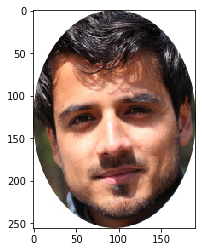

(191, 256)


In [4]:
# Where the data is stored
image_file = '/content/drive/My Drive/HNR 455 - Fall, 2019 - Grove, Kelsey/Final HNR 455 stuff/Dataset/49faces.zip (Unzipped Files)/Publication Friendly 49-Face Database/49 Face Images/9053039024_d553f12079_o.jpg'
# Opening the image
image = PIL.Image.open(image_file)
# Plotting the image
plt.imshow(image)
plt.show()
print(image.size)

From the previous plot, we can see that the size of this specific image is 191 by 256 pixels. When training the GAN, smaller images are more useful because the model will learn the most important features. This GAN was designed to take images that are size 28 by 28.

If we look at every image in the publication friendly dataset, we can see that the images are all different shapes. That makes training the GAN harder, so resizing them to a consistent size is ideal.

In [5]:
folder = '/content/drive/My Drive/HNR 455 - Fall, 2019 - Grove, Kelsey/Final HNR 455 stuff/Dataset/49faces.zip (Unzipped Files)/Publication Friendly 49-Face Database/49 Face Images/'
img_array = []

# Loop through directory to see image sizes
for file in os.listdir(folder):
  if file.endswith('.jpg'):
    img = PIL.Image.open(folder + file)
    print(img.size)  

(208, 256)
(208, 256)
(200, 256)
(184, 256)
(190, 256)
(200, 256)
(234, 256)
(201, 256)
(226, 256)
(240, 256)
(205, 256)
(208, 256)
(210, 256)
(218, 256)
(201, 256)
(194, 256)
(221, 256)
(212, 256)
(188, 256)
(186, 256)
(198, 256)
(180, 256)
(221, 256)
(193, 256)
(190, 256)
(219, 256)
(202, 256)
(183, 256)
(182, 256)
(189, 256)
(193, 256)
(229, 256)
(189, 256)
(197, 256)
(191, 256)
(214, 256)
(200, 256)
(161, 256)
(199, 256)
(204, 256)
(259, 256)
(224, 256)
(175, 256)
(199, 256)
(202, 256)
(191, 256)
(207, 256)
(195, 256)
(196, 256)


I will use the publication friendly images to demonstrate how the images will look after they have been resized by the GAN.

In [0]:
# Folder with dataset of publication friendly images
folder = '/content/drive/My Drive/HNR 455 - Fall, 2019 - Grove, Kelsey/Final HNR 455 stuff/Dataset/49faces.zip (Unzipped Files)/Publication Friendly 49-Face Database/49 Face Images/'

# Array that will contain images
img_array = []

# Desired size of images
size = (28,28)
# Loop through to get images
for file in os.listdir(folder):
  if file.endswith('.jpg'):
#     print(file)
    img = PIL.Image.open(folder + file)
    img = img.resize(size)
#     print(img)
#     plt.imshow(img)
    pix = np.asarray(img)
    img_array.append(pix)

# print(img_array)

As we can see in the plot below, the image is resized to be 28 by 28. The prominate features of the face like the eyes, nose, and mouth stand out much more now.

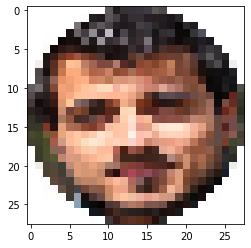

(28, 28, 3)


In [8]:
# Make sure images were resized
plt.imshow(img_array[34])
plt.show()
print(img_array[34].shape) #(height, width, 3 because its in color)

Here I create a loop to save the publication friendly images to Google Drive.

In [0]:
for i in range(len(img_array)):
  plt.imshow(img_array[i])
  plt.savefig("/content/drive/My Drive/HNR 455/Images/%d.png" % i)
  plt.close()

The GAN also scales the pixel values in the images from 0 to 255 to -1 to 1. Scaling these pixel values will standardize the pixels and can potentially speed up training.

In [9]:
# Before pixel values were scaled
print(img_array[34])

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [254 255 250]
  [255 255 255]
  ...
  [254 254 252]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255

In [10]:
# Scale images between -1, 1
for i in range(len(img_array)):
    img_array[i] = ((img_array[i] - img_array[i].min())/(255 - img_array[i].min()))
    img_array[i] = img_array[i]*2-1

# After scaling pixel values
print(img_array[34])

[[[1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  ...
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]]

 [[1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  ...
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]]

 [[1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  ...
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]]

 [[1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  ...
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.       1.       1.      ]
  [1.    

The scaled and resized images are put into the GAN for training. 

####GAN

In [0]:
class GAN():
    def __init__(self):

        # RGB image as an input
        self.img_rows = 28 # The deminisons of the images
        self.img_cols = 28
        self.channels = 3 # Three because RGB
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Optimizers shape and mold your model into it's most accurate possible form by adjusting the weights.
        # optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)
        # optimizer = SGD(lr=0.01, momentum=0.5)
        optimizer = RMSprop(lr=0.0002, rho=0.9)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input 
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)



    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def get_image(self, image_path, width, height, mode):
    
        image = Image.open(image_path)
        # image = image.resize([width, height], Image.BILINEAR)

        #The celebA dataset with human faces was used and cropping the images
        #helps to get better results by eliminating the background pixels
        # if image.size != (width, height):  
        # Remove most pixels that aren't part of a face
            # face_width = face_height = 108
            # j = (image.size[0] - face_width) // 2
            # i = (image.size[1] - face_height) // 2
            # image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height])
    
        return np.array(image.convert(mode))

    def get_batch(self, image_files, width, height, mode):
        data_batch = np.array(
            [self.get_image(sample_file, width, height, mode) for sample_file in image_files])

        return data_batch    

    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Directory where the face images are stored
        data_dir = '/content/drive/My Drive/HNR 455 - Fall, 2019 - Grove, Kelsey/Final HNR 455 stuff/Dataset/10kfaces.zip (Unzipped Files)/10k US Adult Faces Database/Face Images/'

        # Input the images from the directory
        X_train = self.get_batch(glob(os.path.join(data_dir, '*.jpg'))[:5000], 28, 28, 'RGB')
        

        #Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        # Array initialization for logging of the losses
        d_loss_logs_r = []
        d_loss_logs_f = []
        g_loss_logs = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half the batch size of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # Store the losses
            d_loss_logs_r.append([epoch, d_loss[0]])
            d_loss_logs_f.append([epoch, d_loss[1]])
            g_loss_logs.append([epoch, g_loss])



            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)


        d_loss_logs_r_a = np.array(d_loss_logs_r)
        d_loss_logs_f_a = np.array(d_loss_logs_f)
        g_loss_logs_a = np.array(g_loss_logs)

        # At the end of training plot the losses vs epochs
        plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
        plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
        plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GAN')
        plt.grid(True)
        plt.show() 
                    

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = (1/2.5) * gen_imgs + 0.5
        

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/My Drive/HNR 455/Datasets/gan2_output/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=5000, batch_size=32, save_interval=200)

###Final GAN


In [0]:
class GAN():
    def __init__(self):

        # RGB image as an input
        self.img_rows = 28 # The deminisons of the images
        self.img_cols = 28
        self.channels = 3 # Three because RGB
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Optimizers shape and mold your model into its most accurate possible form by adjusting the weights.
        optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input 
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)



    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def get_image(self, image_path, width, height, mode):
    
        # Open and resize images for better results
        image = Image.open(image_path)
        image = image.resize([width, height])
    
        return np.array(image.convert(mode))

    def get_batch(self, image_files, width, height, mode):
        data_batch = np.array(
            [self.get_image(sample_file, width, height, mode) for sample_file in image_files])

        return data_batch    

    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Directory where the dataset is stored
        data_dir = '/content/drive/My Drive/HNR 455 - Fall, 2019 - Grove, Kelsey/Final HNR 455 stuff/Dataset/10kfaces.zip (Unzipped Files)/10k US Adult Faces Database/Face Images/'

        # Input the images from the directory
        X_train = self.get_batch(glob(os.path.join(data_dir, '*.jpg'))[:5000], 28, 28, 'RGB')
        
        #Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)

        # Array initialization for logging of the losses
        d_loss_logs_r = []
        d_loss_logs_f = []
        g_loss_logs = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half the batch size of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Print the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # Store the losses
            d_loss_logs_r.append([epoch, d_loss[0]])
            d_loss_logs_f.append([epoch, d_loss[1]])
            g_loss_logs.append([epoch, g_loss])



            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)


        d_loss_logs_r_a = np.array(d_loss_logs_r)
        d_loss_logs_f_a = np.array(d_loss_logs_f)
        g_loss_logs_a = np.array(g_loss_logs)

        # At the end of training plot the losses vs epochs
        plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
        plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
        plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GAN')
        plt.grid(True)
        plt.show() 
                    

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = (1/2.5) * gen_imgs + 0.5
        

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        # Folder in Google Drive where images are saved
        fig.savefig("/content/drive/My Drive/HNR 455/Datasets/gan2_output/%d.png" % epoch)
        plt.close()

# Run it
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=50000, batch_size=32, save_interval=200)

Output hidden; open in https://colab.research.google.com to view.

As it trains, it will print the loss every 200 intervals. At the end, it will print a plot that tracks the generator loss, discriminator loss, and discriminator accuracy of each interval for however many epochs were run. 